# Natural language processing

Natural language processing (NLP) is a machine learning technique to analyze large amounts of text in order to extract information. Some examples are sentiment analysis, translation, transcription, summarizing and tagging. NLP is a very broad term and can apply to anything text related.

It's also a very hard task for computers because language is a very ill-defined thing. For example,
* Verbs can sometimes be nouns (make, set)
* Words that are spelled the same can have different meanings (spot=stain/availability, fall=season/drop).
* Idioms (hot potato, piece of cake)

Try explaining all of that to a computer! Yet, depending on the goal, that is exactly what we need to do with NLP.

In this notebook, we will use a dataset made available by Yelp that contains reviews of businesses by their customers. These are all short texts that describe if the customer's experience at the business in question. We will apply NLP to analyze the sentiment of each review to find out if it's positive or negative.

## Learning objectives

Average time to complete: 30min

By the end of this tutorial you should be able to:

* Visualize parts of the data and interpret the results of word clouds
* Describe what Sentiment Analysis is and how we use it
* Use the default model

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* We will use NLTK as our machine learning package. NLTK stands for Natural Language Tool Kit.
* The data files that you will need must be downloaded from Yelp yourself

One other package that you will need is "wordcloud" which we will use later to create word clouds. This is not a package that is usually installed by default, so you will need to install it manually. How to do so, depends on your Python environment. If you use Anaconda or Miniconda, you would type the following in the command-line which is a separate program from this this notebook:

    conda install wordcloud

Alternatively you can use Anaconda Navigator to install packages.

For most other Python environments, it would be:

    pip install wordcloud

Once the package is installed successfully, you will likely need to restart the kernel for this notebook. There is a button for that in the toolbar at the top

![Kernel reload button](../data/reload-kernel-button.png)

## RDM best practices

Good data handling for machine learning begins with good Research Data Management (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it. 

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989).

SAVE YOUR RAW DATA IN ORIGINAL FORMAT
* Don't overwrite your original data with a cleaned version.
* Protect your original data by locking them or making them read-only.
* Refer to this original data if things go wrong (as they often do).

BACKUP YOUR DATA
* Use the 3-2-1 rule: Save three copies of your data, on two different storage mediums, and one copy off site. The off site storage can be OneDrive or Google drive or whatever your institution provides.
* We are using Open Data, so it does not contain any personally identifiable data or data that needs to be restricted or protected in any way. However, if your data contains confidential information, it is important to take steps to restrict access and encrypt your data.

There are a few more RDM best practices that will help you in your project management, and we will highlight them at the beginning of each tutorial.


In [1]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import json
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd

## Sentiment analysis
People often have opinions when studying a controversial topic. From online discourse, you can glean a lot of information, but it requires reading every post to see if people feel positive or negative about the topic. NLP can help make this easier. Using the Natural Language Toolkit (NLTK), you will be able to do sentiment analysis.

Sentiment analysis works by creating frequency distributions that correspond to positive texts and distributions that correspond negative text. Then, using those distributions, it is able to tell whether a new text is closer to one distribution than another and thus mark a text as positive or negative.

Yelp provides a free dataset that has a big chunk of their business reviews with over 6 million reviews. This is an excellent dataset for sentiment analysis. It is, however, also really big and you will have to download it from the website yourself. It's important to note that the data has a specific Dataset licence you must agree to. The license details what you are and are not allowed to do with the data.

Download it here: https://www.yelp.com/dataset

The file you download will be called "Yelp-JSON.zip". You will need to extract the files and save them somewhere on your computer. The ZIP file contains a directory called "Yelp JSON" with two files:

* Yelp Dataset Documentation & ToS copy.pdf
* yelp_dataset.tar

The data is contained in the file called "yelp_dataset.tar". A TAR file is like a ZIP file in that it needs to be extracted. Both Linux and macOS can handle this file type natively, but for Windows you need a 3rd party tool like [7-zip](https://www.7-zip.org/) or [WinZip](https://www.winzip.com/en/download/winzip/).

**Note:** In this notebook, we extract the data to "/tmp/yelp" but you will likely have a different path. Adjust any `open` statement below to point to wherever you have stored the json files on your computer.

The dataset is made up of multiple files. Business details and reviews are in different files. The records in those files are all linked with ID numbers.

The data is in JSONL format, which is just a text file containing lots of JSON records with one JSON record on each line. JSON in turn is a markup language that is great at representing unstructured data in a textual format. Python has the JSON library to deal with that. Let's read the first business. Business information is stored in "yelp_academic_dataset_business.json".

In [2]:
with open('/tmp/yelp/yelp_academic_dataset_business.json') as f:
    for line in f:
        business = json.loads(line)
        print(business)
        break # This break statement breaks out of the for loop so only the first line of the JSONL file is read

{'business_id': 'Pns2l4eNsfO8kk83dixA6A', 'name': 'Abby Rappoport, LAC, CMQ', 'address': '1616 Chapala St, Ste 2', 'city': 'Santa Barbara', 'state': 'CA', 'postal_code': '93101', 'latitude': 34.4266787, 'longitude': -119.7111968, 'stars': 5.0, 'review_count': 7, 'is_open': 0, 'attributes': {'ByAppointmentOnly': 'True'}, 'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists', 'hours': None}


The JSON library converted the data into a Python dictionary. You can see the various fields like "business_id", "name", "address" and so on. We want to use the "business_id" next, so we store that in the variable called `business`.

Let's say we are interested in looking at Abby Rappoport. Let's find the reviews that go with that business, which are stored in the list called "yelp_academic_dataset_review.json". The file contains 6 milion reviews from all sorts of businesses. We only want the ones for Abby, but to find them we still need to parse the entire file. So, this will take a few minutes.

The reviews are stored using the "business_id" that we saw when reading "yelp_academic_dataset_business.json". We need to use that ID and compare it to the one used in the reviews file to filter out those reviews.

In [3]:
reviews = []
with open('/tmp/yelp/yelp_academic_dataset_review.json') as f:
    for line in f:
        review = json.loads(line)
        if review['business_id'] == business['business_id']:
            reviews.append(review)

How many reviews did we get?

In [4]:
len(reviews)

7

So we have 7 reviews. Let's see what they say.

In [5]:
reviews

[{'review_id': '9vwYDBVI3ymdqcyJ5WW2Tg',
  'user_id': 'e0imecnX_9MtLnS2rUZM-A',
  'business_id': 'Pns2l4eNsfO8kk83dixA6A',
  'stars': 5.0,
  'useful': 3,
  'funny': 2,
  'cool': 1,
  'text': "I've had acupuncture treatments with Abby over the past few years and I really can't say enough about how great my experiences have been.\n\nShe has successfully treated me for everything from stress to colds to menstrual cramps.  I was amazed that her medical qi gong treatments helped alleviate my chronic back pain.  I didn't think anything could help with that!  \n\nShe is always very clear and upfront about treatments and expectations.   And I love that she always has great advice on herbs, supplements and natural remedies.\n\nShe just relocated to Los Gatos and I'm definitely going to miss having her in San Francisco!",
  'date': '2012-05-02 18:07:38'},
 {'review_id': 'OXgg1LdxHDv3CBU5-xi2lA',
  'user_id': '_Q0fdLVoTnlNkEypUvNkHA',
  'business_id': 'Pns2l4eNsfO8kk83dixA6A',
  'stars': 5.0,
  '

One nice way to visualize reviews (or other texts) is by creating a wordcloud.

To do that we first need to merge all of the reviews into one big text. The following code will take all the "text" entries in the array and join them with newlines.

In [6]:
reviewtext = "\n".join([review['text'] for review in reviews])

Then create the wordcloud using the wordcloud package to plot it. This generates an image that we store in the variable `cloud`.

In [7]:
cloud = wordcloud.WordCloud(background_color='white').generate(reviewtext)

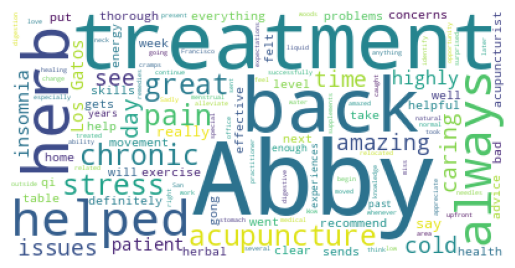

In [8]:
plt.axis('off')
plt.imshow(cloud)

The word cloud is conducted on reviews related to this company. So it reflects the opinions about the company. It also shows what sort of business the company is. You can see that the name Abby features prominently, of course, but you also see that this is a place that does acupuncture and treatments, especially for back pain.

To see if a business is good or not, we can use the stars that people usually give with a review, but this is not always very accurate. People can be very positive in their review but still not give five stars, or people can be a bit unhappy about something minor and go straight to giving one star. To get a better idea of client satisfaction with a business, you'd generally read the actual reviews.

However, if you have lots of businesses and reviews, that will become very time consuming! So, it's better to have a computer to do this. Of course, NLP is hard because language is such an ambiguous thing as mentioned earlier.

Enter machine learning! NLTK has a bunch of pretrained models. One of them is VADER which is good for short texts or sentences. The `SentimentIntensityAnalyzer` will use this model to analyze the reviews.

We first need to download it, but NLTK has a function for that.

In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jvanderk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

comment: if the value above is supposed to be true, please explain what that means.

Then create the analyzer

In [10]:
sia = SentimentIntensityAnalyzer()

Let's see what it thinks of the first review

In [11]:
sia.polarity_scores(reviews[0]['text'])

{'neg': 0.061, 'neu': 0.699, 'pos': 0.24, 'compound': 0.9735}

The number to look for here is compound which combines that negativity, positivity, and neutrality in one easily understandable score that ranges from -1 (BAD!) to 1 (GREAT!).

So in this case, the first review is very close to 1. This must be a very positive review. Let's see what it says.

In [12]:
print(reviews[0]['text'])

I've had acupuncture treatments with Abby over the past few years and I really can't say enough about how great my experiences have been.

She has successfully treated me for everything from stress to colds to menstrual cramps.  I was amazed that her medical qi gong treatments helped alleviate my chronic back pain.  I didn't think anything could help with that!  

She is always very clear and upfront about treatments and expectations.   And I love that she always has great advice on herbs, supplements and natural remedies.

She just relocated to Los Gatos and I'm definitely going to miss having her in San Francisco!


And indeed, that was a very positive review. Let's look at all the reviews now.

In [13]:
for i, review in enumerate(reviews):
    print(i, ':', sia.polarity_scores(review['text'])['compound'])

0 : 0.9735
1 : 0.4304
2 : 0.9573
3 : 0.974
4 : 0.9079
5 : -0.5859
6 : 0.9391


There is one review with index 5 that is pretty negative compared to the others. Let's see what that is about.

In [14]:
print(reviews[5]['text'])

Abby Rappoport helped me achieve a long lost sense of health. I was suffering from debilitating insomnia due to a very stressful job and family requirements. She also was able to get me through a bad bout of bronchitis. 
She is professional, thorough and clearly seasoned as a healthcare provider.
I highly recommend Abby if your situation needs caring attention.


So this was actually a positive review for Abby. However, the language itself is clearly very negative with words like "stress", "debilitating", "bad bout", etc. This example shows that this model isn't always correct, but it is often good enough. Even in this case, based on all of the reviews, it would still classify Abby's business as a very positive experience which is accurate.

We can now combine the codes so far into one bigger code that will analyse the sentiments of multiple businesses. We'll read the first five businesses from the business JSON and get the corresponding reviews for them from the review JSON. Then we run the sentiment analysis on those reviews.

In [15]:
businesses = {}
with open('/tmp/yelp/yelp_academic_dataset_business.json') as businessfile, open('/tmp/yelp/yelp_academic_dataset_review.json') as reviewfile:
    # Read the first businesses into a dictionary. The dictionary key is the ID of the business.
    for i, line in enumerate(businessfile):
        business = json.loads(line)
        businesses[business["business_id"]] = {
            "name": business["name"],
            "reviews": [],
            "sentiments": []
        }
        if i >= 4: # Get the first five
            break

    # Now go through all the reviews and pick the ones that have a business_id that matches any of the businsses we selected.
    for line in reviewfile:
        review = json.loads(line)
        for business_id in businesses.keys():
            if review['business_id'] == business_id:
                businesses[business_id]["reviews"].append(review['text'])
                businesses[business_id]["sentiments"].append(sia.polarity_scores(review['text']))

The variable `businesses` now contains five businesses with their names and all of the reviews and their sentiment analysis. You can view the contents by creating a new cell in this notebook and running `businesses` as code, but it's pretty long.

Now that we have that data, we can see how positive people are about these businesses without relying on stars or anything. It is purely going to be based on the sentiment analysis we just did.

The code below counts all positive sentiments (compount > 0) for each review of each business and compares them to the total reviews for each business. This will give us a summary of the data collected from the code cell above.

In [16]:
for business in businesses.values():
    positive = 0
    total = 0
    for sentiment in business["sentiments"]:
        total += 1
        if sentiment["compound"] > 0:
            positive += 1
    print(f"{business['name']} scores {positive} out of {total}")

Abby Rappoport, LAC, CMQ scores 6 out of 7
The UPS Store scores 13 out of 15
Target scores 24 out of 24
St Honore Pastries scores 76 out of 87
Perkiomen Valley Brewery scores 12 out of 13


We could now do this for the entire dataset, but with so many businesses this is going to take a long time. If you are really interested, you can remove the `if >= 4` limit we have and just let it run for a few days!

## Conclusion

We have seen how sentiment analysis can be used to quantify potentially huge amounts of text to get a sense if people have positive or negative opinions using the built-in pre-trained models that come with NLTK.

You can also train your own models if the default ones are not good enough for your use case. That material goes beyond the scope of these notebooks, but a good tutorial on this can be found at https://realpython.com/python-nltk-sentiment-analysis/.

In the second notebook, we will look at an unsupervised classification algorithm to classify books into group. An unsupervised algorithm does not need any labelled data so it will be purely the computer that comes up with the grouping which can be interesting!